Simulate age and income

In [53]:
import numpy as np

N = 5000

age = np.random.randint(16, 75, N)

Text(0, 0.5, 'Number of customers')

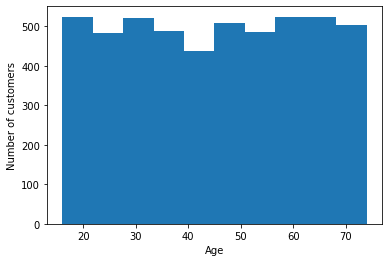

In [54]:
import matplotlib.pyplot as plt

plt.hist(age)
plt.xlabel("Age")
plt.ylabel("Number of customers")

Text(0, 0.5, 'Frequency')

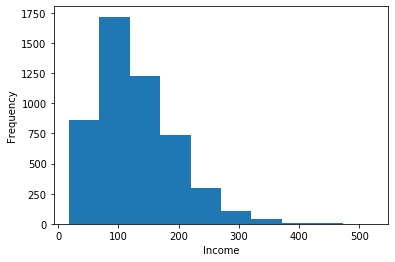

In [55]:
income = age + np.abs(np.random.normal(20, 100, N))

plt.hist(income)
plt.xlabel("Income")
plt.ylabel("Frequency")

In [56]:
def calculate_class(age, income):
    if age < 30:
        if income >= 300:
            return 2
        elif income >= 200:
            return 1
        else:
            return 0
    elif age < 50:
        if income >= 250:
            return 2
        elif income >= 150:
            return 1
        else:
            return 0
    elif age < 60:
        if income >= 150:
            return 2
        elif income >= 75:
            return 1
        else:
            return 0
    else:
        if income >= 200:
            return 2
        elif income >= 150:
            return 1
        else:
            return 0



In [57]:
# calculate event
def calculate_events(age, income):
    if age < 50:
        p = np.array([0.1, 0.75, 0.6, 0.8, 0.5, 0.79, 0.3])
        p = p / p.sum()
        return np.random.choice(7, 1, p=p)[0]
    else:
        p = np.array([0.2, 0.55, 0.65, 0.7, 0.63, 0.70, 0.4])
        p = p / p.sum()
        return np.random.choice(7, 1, p=p).ravel()[0]

Text(0, 0.5, 'Frequency')

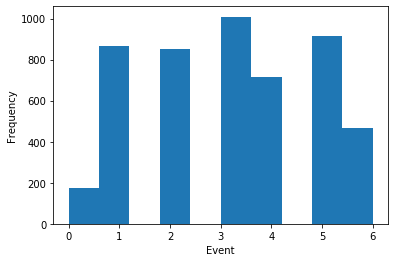

In [58]:
events = list(map(lambda x, y: calculate_events(x, y), age, income))

plt.hist(events)
plt.xlabel("Event")
plt.ylabel("Frequency")

In [59]:
# AIRLINES = 1
# MERCHANDISE = 2
# HOTEL = 3
# ONLINE_PURCHASE = 4
# UTILITIES = 5
# RESTAURANTS = 6
# OTHERS = 7

def calculate_response(age, event):
    if age < 50:
        if event in [2, 3, 4, 6]:
            return 1 if np.random.random() < 0.6 else 0
        else:
            return 1 if np.random.random() < 0.4 else 0
    else:
        if event in [1, 3, 5, 7]:
            return 1 if np.random.random() < 0.6 else 0
        else:
            return 1 if np.random.random() < 0.4 else 0

In [60]:
_class = list(map(lambda x, y: calculate_class(x, y), age, income))

In [61]:
response = list(map(lambda x, y: calculate_response(x, y), age, events))

Text(0, 0.5, 'Frequency')

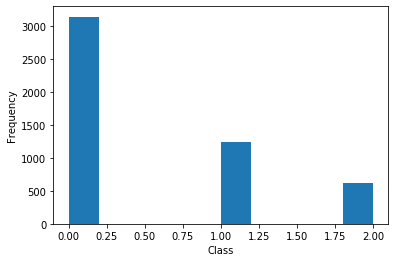

In [62]:
import matplotlib.pyplot as plt

plt.hist(_class)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [65]:
def segmentation(_class, response):
    if _class == 2:
        if response == 1:
            return 2
        else:
            return 1
    elif _class == 1:
        if response == 1:
            return 2
        else:
            return 1
    elif _class == 0:
        if response == 1:
            return 1
        else:
            return 0

In [66]:
segment = list(map(lambda x, y: segmentation(x, y), _class, response))

In [67]:
import pandas as pd

data = {'age': age, 'income': income, 'class': _class, 'response': response, 'segment': segment, 'events': events}
df = pd.DataFrame(data)
df

,age,income,class,response,segment,events
0,27,193.421947,0,0,0,3
1,66,153.595353,1,1,2,5
2,47,53.145987,0,1,1,4
3,17,58.791770,0,0,0,6
4,48,169.981357,1,1,2,2
...,...,...,...,...,...,...
4995,24,29.845263,0,1,1,3
4996,66,206.410585,2,1,2,6
4997,65,210.735462,2,1,2,3
4998,74,113.973763,0,0,0,3


In [68]:
df.describe()

,age,income,class,response,segment,events
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,45.048400,127.562153,0.495400,0.516400,0.888800,3.159000
std,17.114808,64.560881,0.704328,0.499781,0.692915,1.701264
min,16.000000,17.539670,0.000000,0.000000,0.000000,0.000000
25%,30.000000,78.194740,0.000000,0.000000,0.000000,2.000000
50%,45.000000,115.747918,0.000000,1.000000,1.000000,3.000000
75%,60.000000,166.149687,1.000000,1.000000,1.000000,5.000000
max,74.000000,523.262442,2.000000,1.000000,2.000000,6.000000


Text(0.5, 1.0, 'Segment by age and income')

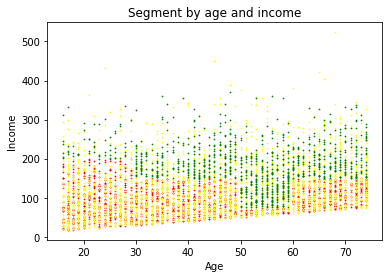

In [69]:
colours = {0: 'red', 1: 'yellow', 2: 'green'}
for segment in [0, 1, 2]:
    df_s = df[df.segment == segment]
    plt.scatter(df_s.age, df_s.income, c=colours[segment], s=0.5)
plt.xlabel("Age")
plt.ylabel("Income")
plt.title("Segment by age and income")

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from nyoka import skl_to_pmml
from sklearn2pmml.pipeline import PMMLPipeline

In [71]:
outputs = df['segment']
inputs = df[['age', 'income', 'response', 'events']]

In [72]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.4, random_state=23)

In [73]:
from sklearn_pandas import DataFrameMapper

def build_RF_pipeline(inputs, outputs, rf=None):
    if not rf:
        rf = RandomForestClassifier()
    pipeline = PMMLPipeline([
        ("mapper", DataFrameMapper([
            (['response', 'events'], preprocessing.OrdinalEncoder()),
            (['age', 'income'], None)
        ])),
        ("classifier", rf)
    ])
    pipeline.fit(inputs, outputs)
    return pipeline

In [74]:
def RF_estimation(inputs, outputs,
                  estimator_steps=10,
                  depth_steps=10,
                  min_samples_split=None,
                  min_samples_leaf=None):
    # hyper-parameter estimation
    n_estimators = [int(x) for x in np.linspace(start=50, stop=100, num=estimator_steps)]
    max_depth = [int(x) for x in np.linspace(3, 10, num=depth_steps)]
    max_depth.append(None)
    if not min_samples_split:
        min_samples_split = [1, 2, 4]
    if not min_samples_leaf:
        min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=random_grid,
                                   n_iter=100, scoring='neg_mean_absolute_error',
                                   cv=3, verbose=1, random_state=42, n_jobs=-1)
    rf_random.fit(inputs, outputs)
    best_random = rf_random.best_estimator_
    print(best_random)
    return best_random

In [75]:
rf = RF_estimation(X_train, y_train, estimator_steps=5, depth_steps=5)
random_forest_pipeline = build_RF_pipeline(X_train, y_train, rf)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.2s finished
From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                      

In [76]:
rf_predictions = random_forest_pipeline.predict(X_test)
print(f"MSE: {random_forest_pipeline.score(X_test, y_test)*100}%")

MSE: 99.85000000000001%


In [77]:
# skl_to_pmml(random_forest_pipeline, ['age', 'income', 'response'], 'segment',"models/rf_segmentation_small.pmml")
from sklearn2pmml import sklearn2pmml

sklearn2pmml(random_forest_pipeline, "models/rf_segmentation_sklearn.pmml", with_repr = True)

In [78]:
# save the sample dataset
df.to_csv("data/dataset.csv")